# a 1950 restart run

This example will run an esemble 1750-1950, save out the outputs in 1950, then use these as initial conditions for future runs.

## Get required imports

In [1]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import pooch
import xarray as xr

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_12092/860352404.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Grab configs and parameter defaults

In [2]:
fair_params_1_2_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/8399112/files/calibrated_constrained_parameters.csv',
    known_hash = 'md5:de3b83432b9d071efdd1427ad31e9076',
)

In [3]:
solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)
volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)
df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj)

solar_forcing = np.zeros(551)
volcanic_forcing = np.zeros(551)
volcanic_forcing[:352] = df_volcanic.erf.values
solar_forcing = df_solar["erf"].loc[1750:2300].values

trend_shape = np.ones(551)
trend_shape[:271] = np.linspace(0, 1, 271)

In [4]:
df_configs = pd.read_csv(fair_params_1_2_0_obj, index_col=0)
num_members = 100
df_configs = df_configs.sample(num_members, random_state=42)
configs = df_configs.index  # this is used as a label for the "config" axis

In [5]:
scenarios = ['ssp585']

In [6]:
species, properties = read_properties(filename='data/species_configs_properties_calibration1.2.0.csv')

## Set up first 1750-1950 run

In [7]:
f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 1950, 1)
f.define_scenarios(["ssp585"])  # this doesn't matter, they are all the same historically, as long as fill_from_rcmip() knows it
f.define_configs(configs)
f.define_species(species, properties)

In [8]:
f.allocate()

In [9]:
f.fill_from_rcmip()

### Do the hacky NOx correction

Note dataframe indices are 1750 to 1950 and in the last line we only want years 0-200

In [10]:
rcmip_emissions_file = pooch.retrieve(
    url="doi:10.5281/zenodo.4589756/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash="md5:4044106f55ca65b094670e7577eaf9b3",
)
df_emis = pd.read_csv(rcmip_emissions_file)
gfed_sectors = [
    "Emissions|NOx|MAGICC AFOLU|Agricultural Waste Burning",
    "Emissions|NOx|MAGICC AFOLU|Forest Burning",
    "Emissions|NOx|MAGICC AFOLU|Grassland Burning",
    "Emissions|NOx|MAGICC AFOLU|Peat Burning",
]
for scenario in scenarios:
    f.emissions.loc[dict(specie="NOx", scenario=scenario)] = (
        df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"].isin(gfed_sectors)),
            "1750":"1950",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        .sum(axis=0)
        * 46.006
        / 30.006
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC AFOLU|Agriculture"),
            "1750":"1950",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC Fossil and Industrial"),
            "1750":"1950",
        ]
        .interpolate(axis=1)
        .values.squeeze()
    )[:200, None]

### Fill in everything

Again for solar and volcanic forcing we only want the first 200 years (=201 timebounds) of the forcing time series

In [11]:
fill(
    f.forcing,
    volcanic_forcing[:201, None, None] * df_configs["fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:201, None, None] * df_configs["fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:201, None, None] * df_configs["fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

In [12]:
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "clim_c1":"clim_c3"].values)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs["clim_epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs["clim_gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], True)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

In [13]:
f.fill_species_configs(filename='data/species_configs_properties_calibration1.2.0.csv')

In [14]:
# carbon cycle
fill(f.species_configs["iirf_0"], df_configs["cc_r0"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_airborne"], df_configs["cc_rA"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_uptake"], df_configs["cc_rU"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_temperature"], df_configs["cc_rT"].values.squeeze(), specie="CO2")

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs["aci_beta"].values.squeeze())
fill(f.species_configs["aci_shape"], df_configs["aci_shape_so2"].values.squeeze(), specie="Sulfur")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_bc"].values.squeeze(), specie="BC")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_oc"].values.squeeze(), specie="OC")

# aerosol direct
for specie in [
    "BC", 
    "CH4", 
    "N2O",
    "NH3", 
    "NOx",
    "OC", 
    "Sulfur", 
    "VOC",
    "Equivalent effective stratospheric chlorine"
]:
    fill(f.species_configs["erfari_radiative_efficiency"], df_configs[f"ari_{specie}"], specie=specie)

# forcing scaling
for specie in [
    "CO2", 
    "CH4", 
    "N2O", 
    "Stratospheric water vapour",
    "Contrails", 
    "Light absorbing particles on snow and ice", 
    "Land use"
]:
    fill(f.species_configs["forcing_scale"], df_configs[f"fscale_{specie}"].values.squeeze(), specie=specie)
# the halogenated gases all take the same scale factor
for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(f.species_configs["forcing_scale"], df_configs["fscale_minorGHG"].values.squeeze(), specie=specie)

# ozone
for specie in ["CH4", "N2O", "Equivalent effective stratospheric chlorine", "CO", "VOC", "NOx"]:
    fill(f.species_configs["ozone_radiative_efficiency"], df_configs[f"o3_{specie}"], specie=specie)

# initial value of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"], 
    df_configs["cc_co2_concentration_1750"].values.squeeze(), 
    specie="CO2"
)

### 1750 initial conditions

In [15]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

## Run and save outputs

In [16]:
f.run()

Running 100 projections in parallel:   0%|          | 0/200 [00:00<?, ?timesteps/s]

In [17]:
weights = np.ones(52)
weights[0] = 0.5
weights[-1]= 0.5

# these values are to be subtracted from your surface temperature output in reporting
offset1850_1900 = np.average(f.temperature.sel(layer=0, scenario='ssp585', timebounds=np.arange(1850, 1902)), weights=weights, axis=0)
offset1850_1900

array([ 6.46027636e-02,  1.76280499e-02,  7.52388559e-02,  7.01369177e-02,
        7.46966813e-02,  1.02999290e-01,  5.08858907e-02,  2.34552711e-03,
        7.25385870e-02,  1.29009676e-01,  3.94339170e-03, -5.28536131e-05,
       -2.38590915e-02,  2.80235201e-02,  1.44962699e-02,  4.16482611e-02,
        3.60374075e-02,  6.65232629e-02,  5.21468597e-02,  6.60105568e-02,
        2.86945336e-02, -9.26359756e-03,  3.67740908e-02, -6.67739990e-03,
       -2.21882643e-02,  1.16869685e-01,  6.87522112e-02,  3.55440501e-03,
        2.30526724e-02, -5.17639315e-03,  4.22661560e-04,  9.48051216e-02,
        9.42082640e-02, -3.27919151e-02,  4.32278121e-02,  6.68440650e-02,
       -2.23561682e-02, -3.23304582e-02, -4.44832677e-02, -1.11567590e-01,
        1.45552904e-01, -1.82548813e-02,  2.34115495e-02, -2.83483165e-02,
       -2.14963650e-02,  1.23965991e-01, -2.22877134e-02,  9.20870838e-02,
       -2.14473268e-02,  1.86031274e-01,  4.86359593e-02,  4.66358130e-02,
       -4.47142059e-02, -

In [18]:
f.airborne_emissions[-1,...].to_netcdf('initial_1950_100/airborne_emissions.nc')
f.concentration[-1,...].to_netcdf('initial_1950_100/concentration.nc')
f.cumulative_emissions[-1,...].to_netcdf('initial_1950_100/cumulative_emissions.nc')
f.forcing[-1,...].to_netcdf('initial_1950_100/forcing.nc')
f.temperature[-1,...].to_netcdf('initial_1950_100/temperature.nc')
f.gas_partitions.to_netcdf('initial_1950_100/gas_partitions.nc')
np.save('initial_1950_100/preindustrial_temperature.npy', offset1850_1900)

## Re-do everything with these 1950 ICs

In [19]:
f = FAIR(ch4_method="Thornhill2021")
f.define_time(1950, 2101, 1)
f.define_scenarios(["ssp585"])
f.define_configs(configs)
f.define_species(species, properties)
f.allocate()
f.fill_from_rcmip()

Be careful with index values

In [20]:
rcmip_emissions_file = pooch.retrieve(
    url="doi:10.5281/zenodo.4589756/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash="md5:4044106f55ca65b094670e7577eaf9b3",
)
df_emis = pd.read_csv(rcmip_emissions_file)
gfed_sectors = [
    "Emissions|NOx|MAGICC AFOLU|Agricultural Waste Burning",
    "Emissions|NOx|MAGICC AFOLU|Forest Burning",
    "Emissions|NOx|MAGICC AFOLU|Grassland Burning",
    "Emissions|NOx|MAGICC AFOLU|Peat Burning",
]
for scenario in scenarios:
    f.emissions.loc[dict(specie="NOx", scenario=scenario)] = (
        df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"].isin(gfed_sectors)),
            "1950":"2100",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        .sum(axis=0)
        * 46.006
        / 30.006
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC AFOLU|Agriculture"),
            "1950":"2100",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC Fossil and Industrial"),
            "1950":"2100",
        ]
        .interpolate(axis=1)
        .values.squeeze()
    )[:151, None]

In [21]:
fill(
    f.forcing,
    volcanic_forcing[200:352, None, None] * df_configs["fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[200:352, None, None] * df_configs["fscale_solar_amplitude"].values.squeeze()
    + trend_shape[200:352, None, None] * df_configs["fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

In [22]:
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "clim_c1":"clim_c3"].values)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs["clim_epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs["clim_gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], True)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

f.fill_species_configs(filename='data/species_configs_properties_calibration1.2.0.csv')

# carbon cycle
fill(f.species_configs["iirf_0"], df_configs["cc_r0"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_airborne"], df_configs["cc_rA"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_uptake"], df_configs["cc_rU"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_temperature"], df_configs["cc_rT"].values.squeeze(), specie="CO2")

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs["aci_beta"].values.squeeze())
fill(f.species_configs["aci_shape"], df_configs["aci_shape_so2"].values.squeeze(), specie="Sulfur")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_bc"].values.squeeze(), specie="BC")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_oc"].values.squeeze(), specie="OC")

# aerosol direct
for specie in [
    "BC", 
    "CH4", 
    "N2O",
    "NH3", 
    "NOx",
    "OC", 
    "Sulfur", 
    "VOC",
    "Equivalent effective stratospheric chlorine"
]:
    fill(f.species_configs["erfari_radiative_efficiency"], df_configs[f"ari_{specie}"], specie=specie)

# forcing scaling
for specie in [
    "CO2", 
    "CH4", 
    "N2O", 
    "Stratospheric water vapour",
    "Contrails", 
    "Light absorbing particles on snow and ice", 
    "Land use"
]:
    fill(f.species_configs["forcing_scale"], df_configs[f"fscale_{specie}"].values.squeeze(), specie=specie)
# the halogenated gases all take the same scale factor
for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(f.species_configs["forcing_scale"], df_configs["fscale_minorGHG"].values.squeeze(), specie=specie)

# ozone
for specie in ["CH4", "N2O", "Equivalent effective stratospheric chlorine", "CO", "VOC", "NOx"]:
    fill(f.species_configs["ozone_radiative_efficiency"], df_configs[f"o3_{specie}"], specie=specie)

# initial value of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"], 
    df_configs["cc_co2_concentration_1750"].values.squeeze(), 
    specie="CO2"
)

## 1950 initial conditions

In [23]:
concentration = xr.load_dataarray('initial_1950_100/concentration.nc')
forcing = xr.load_dataarray('initial_1950_100/forcing.nc')
temperature = xr.load_dataarray('initial_1950_100/temperature.nc')
cumulative_emissions = xr.load_dataarray('initial_1950_100/cumulative_emissions.nc')
airborne_emissions = xr.load_dataarray('initial_1950_100/airborne_emissions.nc')
gas_partitions = xr.load_dataarray('initial_1950_100/gas_partitions.nc')

In [24]:
initialise(f.concentration, concentration)
initialise(f.forcing, forcing)
initialise(f.temperature, temperature)
initialise(f.cumulative_emissions, cumulative_emissions)
initialise(f.airborne_emissions, airborne_emissions)
f.gas_partitions = gas_partitions

## run

In [25]:
f.run()

Running 100 projections in parallel:   0%|          | 0/151 [00:00<?, ?timesteps/s]

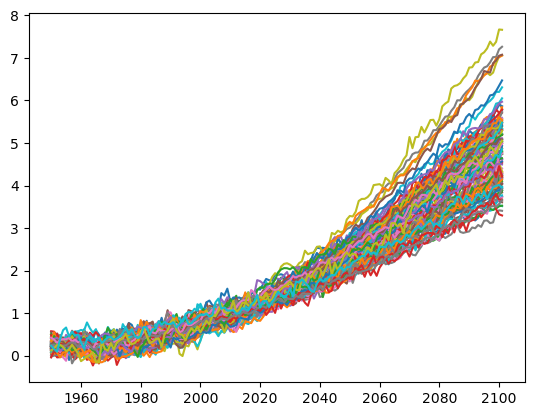

In [26]:
pl.plot(f.timebounds, f.temperature.sel(layer=0, scenario='ssp585'));

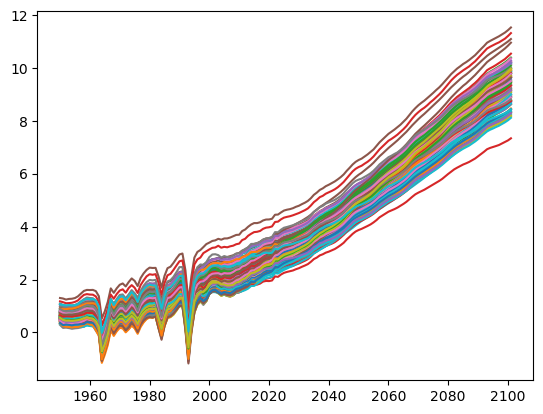

In [27]:
pl.plot(f.timebounds, f.forcing_sum.sel(scenario='ssp585'));

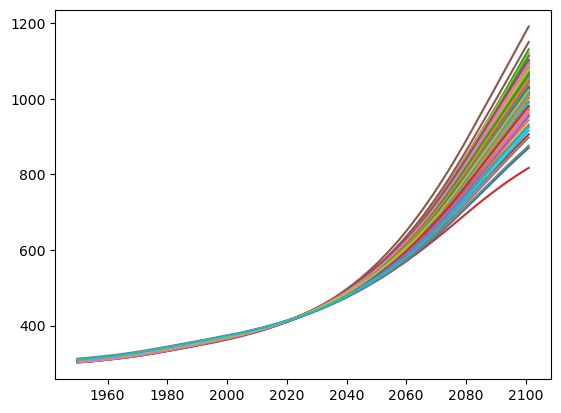

In [28]:
pl.plot(f.timebounds, f.concentration.sel(scenario='ssp585', specie='CO2'));